# Kullanacağımız Kütüphaneler

### Burada kullanacağımız kütüphaneleri import ediyoruz.

In [32]:
import os   # Dosya yolları,klasör işlemleri için
import numpy as np   # Matematiksel işlemler için(array,tensör vs)
import pandas as pd   # Tablo ve veri işleme için
import matplotlib.pyplot as plt    # Görselleştirme(grafik,resim)
import itertools      # Kombinasyon/permutasyon gibi işlemler.
from glob import glob    # Belirli dosya uzantılarını bulmak için
from sklearn.metrics import confusion_matrix, classification_report   # Modelin performansını ölçmek için
import seaborn as sns     # Isı haritası,confusion matrix görselleştirme
import tensorflow as tf   # Derin öğrenme kütüphanesi
from tensorflow.keras.preprocessing.image import ImageDataGenerator    # Görselleri augment etmek için(çevirme,zoom,normalize)
from tensorflow.keras import layers, models, optimizers    # Model kurma ve eğitme
from tensorflow.keras.applications import EfficientNetB0    # Önceden eğitilmiş,hazır CNN mimarisi
from tensorflow.keras.applications.efficientnet import preprocess_input as ef_preprocess   # EfficientNet için özel preprocessing fonksiyonu
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau   # Eğitim sürecinde model kaydetme,erken durdurma,öğrenme oranı azaltma
import cv2 # Görüntü işleme,Grad-CAM görselleştirme için
import warnings # Uyarı mesajlarını gizlemek için
from warnings import filterwarnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
filterwarnings("ignore")

print("TensorFlow sürümü:", tf.__version__)
print("Keras sürümü:", tf.keras.__version__)

TensorFlow sürümü: 2.18.0
Keras sürümü: 3.8.0


# Dosya Yolları

In [33]:
BASE_DIR = "/kaggle/input/intel-image-classification"  # Kaggle'da dataset'in otomatik monte edildiği ana yol

# Train, test ve prediction dizin yolları
train_dir = os.path.join(BASE_DIR, "seg_train", "seg_train")
test_dir = os.path.join(BASE_DIR, "seg_test", "seg_test")
pred_dir = os.path.join(BASE_DIR, "seg_pred", "seg_pred") # Bu klasör genellikle etiketsizdir, direk tahmin için kullanılır.

print(f"Eğitim dizini (train_dir): {train_dir}")
print(f"Test dizini (test_dir): {test_dir}")
print(f"Tahmin dizini (pred_dir): {pred_dir}")



Eğitim dizini (train_dir): /kaggle/input/intel-image-classification/seg_train/seg_train
Test dizini (test_dir): /kaggle/input/intel-image-classification/seg_test/seg_test
Tahmin dizini (pred_dir): /kaggle/input/intel-image-classification/seg_pred/seg_pred


# Dataseti Hakkında Bilgiler


Veri Seti Sınıfları: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Toplam sınıf sayısı: 6

Eğitim veri setinde sınıf başına örnek sayıları: {'buildings': 2191, 'forest': 2271, 'glacier': 2404, 'mountain': 2512, 'sea': 2274, 'street': 2382}


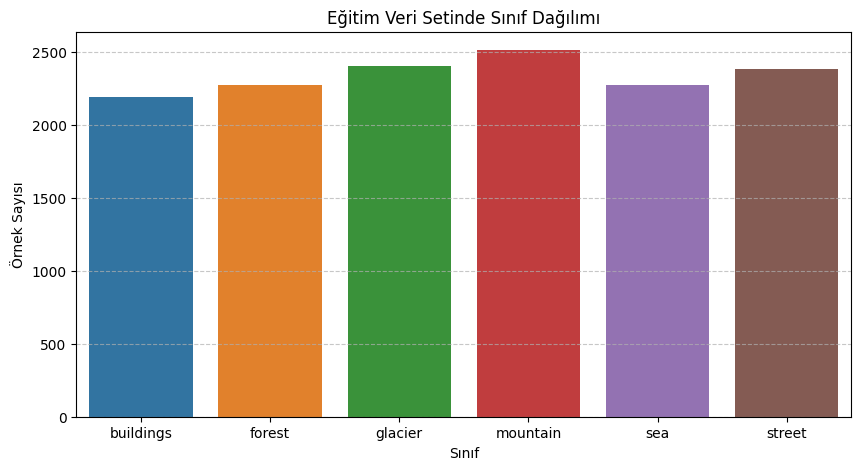

In [34]:
# Eğitim klasöründeki alt dizinlerden sınıf isimlerini alır.
classes = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])
print(f"\nVeri Seti Sınıfları: {classes}")
print(f"Toplam sınıf sayısı: {len(classes)}")

# Her sınıf için eğitim veri setindeki örnek sayısını hesaplar ve görselleştirir.
counts = {c: len(os.listdir(os.path.join(train_dir, c))) for c in classes}
print(f"\nEğitim veri setinde sınıf başına örnek sayıları: {counts}")

# Sınıf dağılımını bar grafiği ile gösterir.
plt.figure(figsize=(10, 5))
sns.barplot(x=list(counts.keys()), y=list(counts.values()))
plt.title('Eğitim Veri Setinde Sınıf Dağılımı')
plt.xlabel('Sınıf')
plt.ylabel('Örnek Sayısı')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

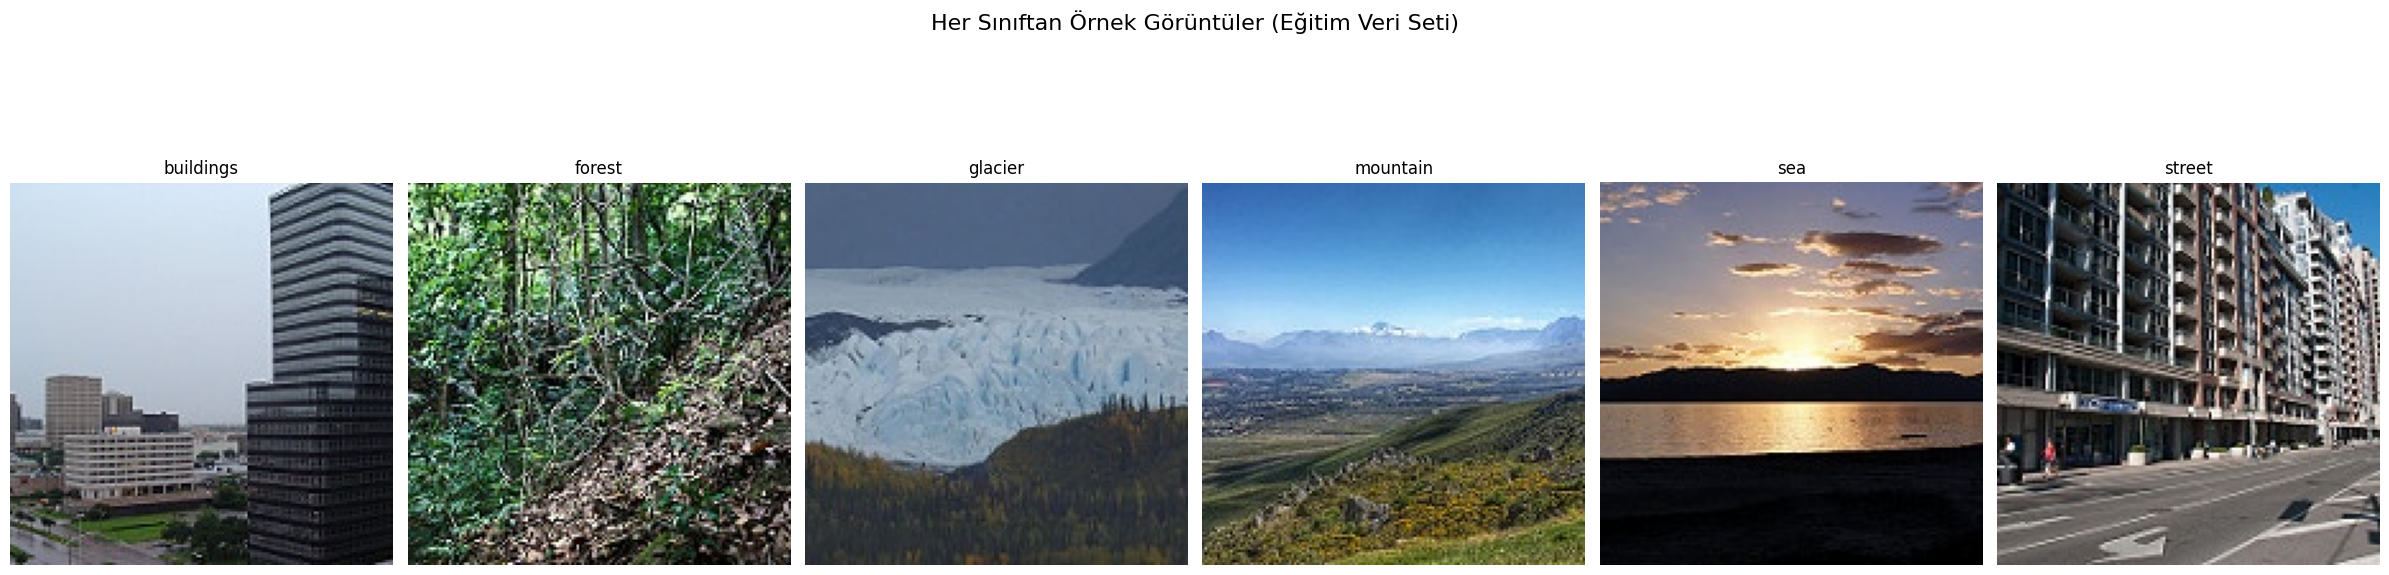

In [35]:
# Her sınıftan rastgele birer örnek görselleştirir.
def show_sample_images(folder, classes, ncols=6):
    plt.figure(figsize=(24, 12))
    plt.suptitle("Her Sınıftan Örnek Görüntüler (Eğitim Veri Seti)", fontsize=16)
    i = 1
    for c in classes:
        files = glob(os.path.join(folder, c, "*.jpg"))
        if len(files) == 0:
            print(f"Uyarı: '{c}' sınıfı için görüntü bulunamadı.")
            continue
        img_path = files[np.random.randint(len(files))] # Rastgele bir görüntü seç
        img = plt.imread(img_path)
        plt.subplot(2, ncols, i)
        plt.imshow(img)
        plt.title(c, fontsize=12)
        plt.axis('off')
        i += 1
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Suptitle ile çakışmayı önler
    plt.show()

show_sample_images(train_dir, classes)

# Veri Ön İşleme ve Veri Çoğaltma (Data Augmentation)

In [36]:
IMG_SIZE = (150, 150)  # Tüm görüntüler bu boyuta yeniden boyutlandırılacaktır.
BATCH_SIZE = 32        # Her eğitim adımında kullanılacak resim sayısı.
SEED = 42              # Yeniden üretilebilir sonuçlar için sabit seed.

# ImageDataGenerator: Eğitim ve doğrulama için
# Aşağıdaki teknikler data augmentation (veri çoğaltma) sayesinde modelin genelleme gücünü artırır (overfitting’i azaltır).
train_datagen = ImageDataGenerator(
    preprocessing_function=ef_preprocess,  # EfficientNet(hazır model) için özelleşmiş ön işleme fonksiyonu
    rotation_range=20,                     # Rastgele 20 dereceye kadar döndürme
    width_shift_range=0.1,                 # Genişliğin %10'u kadar yatay kaydırma
    height_shift_range=0.1,                # Yüksekliğin %10'u kadar dikey kaydırma
    shear_range=0.1,                       # Kırpma (shear transformation)
    zoom_range=0.15,                       # %15'e kadar rastgele yakınlaştırma
    horizontal_flip=True,                  # Yatay çevirme
    fill_mode="nearest",                   # Boş piksellerin doldurma yöntemi
    validation_split=0.2                   # Eğitim setinin %20'si doğrulama için ayrılır
)

# Train Generator 
train_generator = train_datagen.flow_from_directory(
    train_dir,                 # Eğitim görsellerinin olduğu klasör
    target_size=IMG_SIZE,      # Görselleri 150*150 boyutuna getirir.
    batch_size=BATCH_SIZE,     # BATCH_SIZE = 32
    class_mode='categorical',  # Çok sınıflı sınıflandırma(one-hot encoding) için
    shuffle=True,              # Veriyi karıştır
    subset='training',         # %80’i eğitim için alınır (geri kalan %20 validation olacak).
    seed=SEED
)

# Doğrulama veri jeneratörü
val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,                         # Doğrulama için karıştırmaya gerek yok
    subset='validation',                   # Eğitim verisinden ayrılan %20’lik kısım kullanılır.
    seed=SEED
)

# Test veri jeneratörü (ayrı test klasörü için)
# Test verisine augmentation uygulanmaz, sadece ön işleme yapılır.
test_datagen = ImageDataGenerator(preprocessing_function=ef_preprocess)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False                         # Test için karıştırmaya gerek yok
)

print(f"\nEğitim verisi için {train_generator.samples} görüntü bulundu.")
print(f"Doğrulama verisi için {val_generator.samples} görüntü bulundu.")
print(f"Test verisi için {test_generator.samples} görüntü bulundu.")

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.

Eğitim verisi için 11230 görüntü bulundu.
Doğrulama verisi için 2804 görüntü bulundu.
Test verisi için 3000 görüntü bulundu.


# CNN Modelinin Oluşturulması

In [37]:
# CNN(Convolutional Neural Network)
def build_simple_cnn(input_shape, n_classes):
    
    model = models.Sequential([
        layers.Input(shape=input_shape),                           # Modelin giriş boyutunu tanımlıyor.
        layers.Conv2D(32, (3,3), activation='relu', padding='same'), # 32 filtreli 3x3 konvolüsyon katmanı
        layers.BatchNormalization(),                                 # Her katmandan çıkan aktivasyonları normalize eder.
        layers.MaxPooling2D(2,2),                                    # 2x2 Max Pooling
        layers.Conv2D(64, (3,3), activation='relu', padding='same'), # 64 filtreli konvolüsyon katmanı
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),# 128 filtreli konvolüsyon katmanı
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),
        layers.Flatten(),                                          # Çıktıyı tek boyutlu hale getirir.CNN kısmından gelen bilgiyi, klasik yapay sinir ağına bağlar.
        layers.Dense(256, activation='relu'),                      # 256 nöronlu tam bağlantılı katman
        layers.Dropout(0.5),                                       # Overfitting'i azaltmak için %50 dropout.%50 oranında nöronları geçici olarak kapatır.
        layers.Dense(n_classes, activation='softmax')              # Çıkış katmanı (sınıf sayısı kadar nöron)
    ])
    # Modelin derlenmesi: Adam optimizer, categorical_crossentropy kaybı ve doğruluk metriği ile
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Basit CNN modelini oluştur
simple_model = build_simple_cnn(input_shape=IMG_SIZE+(3,), n_classes=len(classes))
print(" CNN Modeli Özeti ")
simple_model.summary()

 CNN Modeli Özeti 


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │    10,617,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,712,774 (40.87 MB)

 Trainable params: 10,712,326 (40.86 MB)

 Non-trainable params: 448 (1.75 KB)

# CNN Modeli Eğitimi

In [38]:
print("\n CNN Modeli Eğitimi Başlatılıyor.")

# Geri Çağrımlar (Callbacks) tanımlanması
# Callbacks, model eğitimi sırasında otomatik olarak belirli işlemleri yapan yardımcılardır.
# Overfitting'i önlemek ve eğitim sürecini optimize etmek için kullanılırlar.
callbacks_simple_cnn = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1), # Doğrulama kaybı 8 epoch boyunca iyileşmezse durdur
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-7, verbose=1), # Doğrulama kaybı plato yaparsa öğrenme oranını yarıya düşür
    ModelCheckpoint("simple_cnn_best.h5", save_best_only=True, monitor='val_loss', verbose=1) # En iyi doğrulama kaybına sahip modeli kaydet
]

EPOCHS_SIMPLE_CNN = 25 # CNN için belirlenen maksimum epoch sayısı
history_simple = simple_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS_SIMPLE_CNN,
    callbacks=callbacks_simple_cnn,
    verbose=1
)
print(" CNN Modeli Eğitimi Tamamlandı.")


 CNN Modeli Eğitimi Başlatılıyor.
Epoch 1/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.4060 - loss: 4.7761
Epoch 1: val_loss improved from inf to 1.16028, saving model to simple_cnn_best.h5
351/351 ━━━━━━━━━━━━━━━━━━━━ 98s 264ms/step - accuracy: 0.4060 - loss: 4.7692 - val_accuracy: 0.5624 - val_loss: 1.1603 - learning_rate: 0.0010
Epoch 2/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.4768 - loss: 1.3209
Epoch 2: val_loss did not improve from 1.16028
351/351 ━━━━━━━━━━━━━━━━━━━━ 88s 252ms/step - accuracy: 0.4768 - loss: 1.3208 - val_accuracy: 0.5300 - val_loss: 1.2005 - learning_rate: 0.0010
Epoch 3/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.5207 - loss: 1.2004
Epoch 3: val_loss did not improve from 1.16028
351/351 ━━━━━━━━━━━━━━━━━━━━ 87s 247ms/step - accuracy: 0.5207 - loss: 1.2004 - val_accuracy: 0.4016 - val_loss: 2.4083 - learning_rate: 0.0010
Epoch 4/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.5228 - loss: 1.1656
Epoc

# Accuracy / Loss Grafikleri (CNN Model)

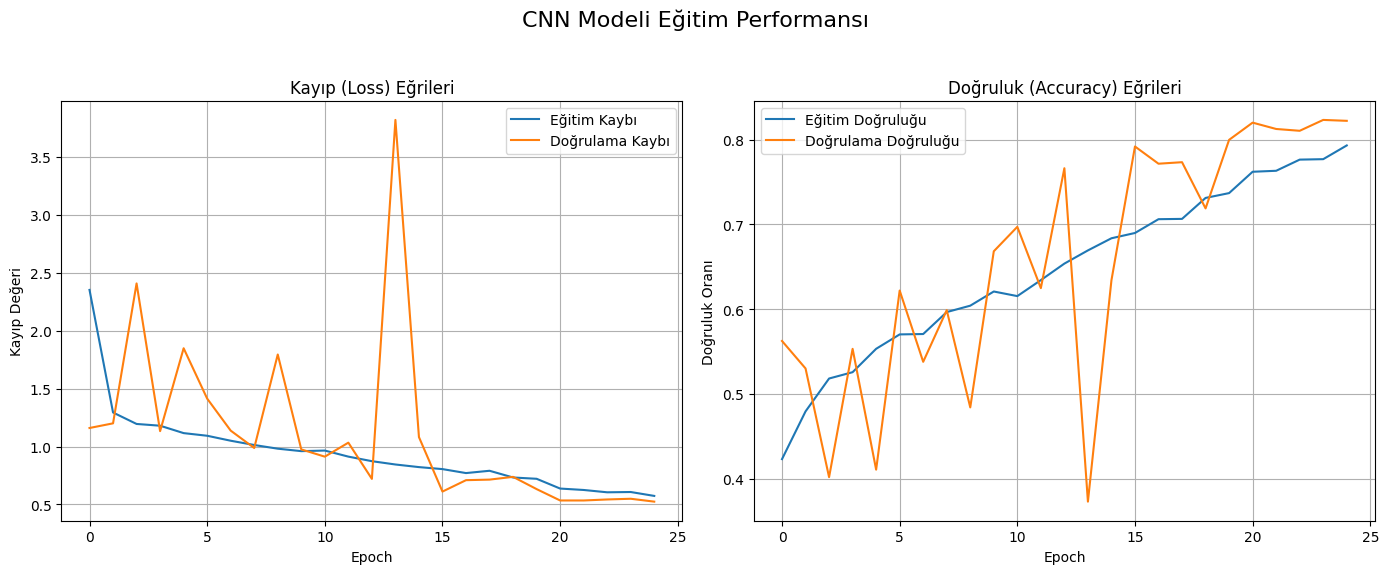

In [42]:
# Bu grafikler, modelin overfitting veya underfitting yapıp yapmadığını anlamak için kritik öneme sahiptir.

def plot_history(h, title="Eğitim ve Doğrulama Metrikleri"):

    plt.figure(figsize=(14, 6))
    plt.suptitle(title, fontsize=16)

    # Kayıp (Loss) grafiği
    plt.subplot(1, 2, 1)
    plt.plot(h.history['loss'], label='Eğitim Kaybı')
    plt.plot(h.history['val_loss'], label='Doğrulama Kaybı')
    plt.title('Kayıp (Loss) Eğrileri')
    plt.xlabel('Epoch')
    plt.ylabel('Kayıp Değeri')
    plt.legend()
    plt.grid(True)

    # Doğruluk (Accuracy) grafiği
    plt.subplot(1, 2, 2)
    plt.plot(h.history['accuracy'], label='Eğitim Doğruluğu')
    plt.plot(h.history['val_accuracy'], label='Doğrulama Doğruluğu')
    plt.title('Doğruluk (Accuracy) Eğrileri')
    plt.xlabel('Epoch')
    plt.ylabel('Doğruluk Oranı')
    plt.legend()
    plt.grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Suptitle ile çakışmayı önler
    plt.show()

# Basit CNN modelinin eğitim grafiklerini çiz
plot_history(history_simple, "CNN Modeli Eğitim Performansı")


# Transfer Learning ile EfficientNetB0 Modeli

In [43]:
# EfficientNetB0 gibi ImageNet üzerinde önceden eğitilmiş (pretrained) güçlü bir CNN modelini kullanıyoruz.
# EfficientNetB0 gibi önceden eğitilmiş bir modeli temel alarak daha güçlü bir model oluşturulur.
# Model başlangıçta dondurulur (frozen), böylece sadece üst katmanlar eğitilir.
print("\n--- EfficientNetB0 ile Transfer Öğrenme Modeli Oluşturuluyor ---")

# EfficientNetB0 modelini ImageNet ağırlıklarıyla yükle.
# include_top=False: Modelin üst sınıflandırma katmanlarını dahil etme.
# weights='imagenet': ImageNet veri setinde eğitilmiş ağırlıkları kullan.
# input_shape: Giriş görüntülerinin beklenen boyutu.
base_model = EfficientNetB0(include_top=False,
                            weights='imagenet',
                            input_shape=IMG_SIZE+(3,),
                            pooling='avg') # Global Average Pooling kullanır, flatten'a gerek kalmaz

# İlk etapta temel modeli dondur (ağırlıkları eğitilmeyecek)
# Bu, önceden öğrenilmiş özelliklerin korunmasını ve sadece yeni eklenen katmanların eğitilmesini sağlar.
base_model.trainable = False

# Yeni sınıflandırma katmanları ekle
inputs = layers.Input(shape=IMG_SIZE+(3,))
x = base_model(inputs, training=False) # Base modelin eğitim modunu kapalı tut
x = layers.BatchNormalization()(x)     # Ekstra normalizasyon, performans artırabilir
x = layers.Dropout(0.4)(x)             # %40 dropout
x = layers.Dense(256, activation='relu')(x) # 256 nöronlu tam bağlantılı katman (ReLU aktivasyon)
x = layers.Dropout(0.3)(x)             # %30 dropout
outputs = layers.Dense(len(classes), activation='softmax')(x) # Çıkış katmanı (softmax aktivasyon)

# Yeni modelimizi oluştur
eff_model = tf.keras.Model(inputs, outputs)

# Modelin derlenmesi: Başlangıçta daha düşük bir öğrenme oranıyla Adam optimizer kullanırız.
eff_model.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

print("--- EfficientNetB0 Modeli Özeti (Frozen Base) ---")
eff_model.summary()


--- EfficientNetB0 ile Transfer Öğrenme Modeli Oluşturuluyor ---
--- EfficientNetB0 Modeli Özeti (Frozen Base) ---


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,384,169 (16.72 MB)

 Trainable params: 332,038 (1.27 MB)

 Non-trainable params: 4,052,131 (15.46 MB)

# Efficient Model Eğitimi


 EfficientNetB0 Eğitimi Başlatılıyor - Aşama 1 (Base Model Dondurulmuş) 
Epoch 1/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.7706 - loss: 0.7097
Epoch 1: val_loss improved from inf to 0.26115, saving model to effnet_b0_stage1.h5
351/351 ━━━━━━━━━━━━━━━━━━━━ 130s 298ms/step - accuracy: 0.7707 - loss: 0.7092 - val_accuracy: 0.9012 - val_loss: 0.2611 - learning_rate: 0.0010
Epoch 2/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.8647 - loss: 0.3888
Epoch 2: val_loss did not improve from 0.26115
351/351 ━━━━━━━━━━━━━━━━━━━━ 84s 240ms/step - accuracy: 0.8648 - loss: 0.3888 - val_accuracy: 0.8984 - val_loss: 0.2667 - learning_rate: 0.0010
Epoch 3/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.8888 - loss: 0.3182
Epoch 3: val_loss did not improve from 0.26115
351/351 ━━━━━━━━━━━━━━━━━━━━ 83s 237ms/step - accuracy: 0.8888 - loss: 0.3183 - val_accuracy: 0.9037 - val_loss: 0.2680 - learning_rate: 0.0010
Epoch 4/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/st

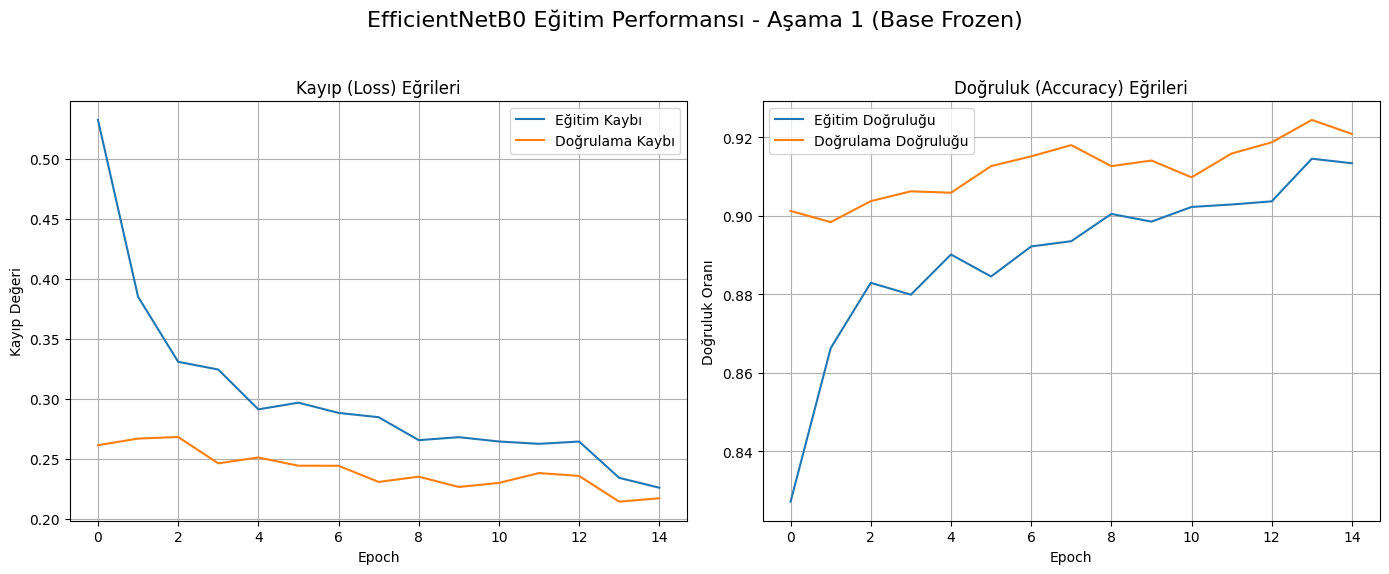

In [44]:
# Temel modelin dondurulmuş olduğu bu aşamada, sadece yeni eklenen sınıflandırma katmanları eğitilir.
# Bu, önceden eğitilmiş ağırlıkların bozulmasını önler ve modelin yeni veri setine adaptasyonunu hızlandırır.
print("\n EfficientNetB0 Eğitimi Başlatılıyor - Aşama 1 (Base Model Dondurulmuş) ")

# Callbacks tanımlanması (benzer amaçlarla)
callbacks_eff_stage1 = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1),
    ModelCheckpoint("effnet_b0_stage1.h5", save_best_only=True, monitor='val_loss', verbose=1)
]

EPOCHS_STAGE1 = 15 # İlk aşama için epoch sayısı
history_eff_1 = eff_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS_STAGE1,
    callbacks=callbacks_eff_stage1,
    verbose=1
)
print("EfficientNetB0 Eğitimi Tamamlandı - Aşama 1 ")

# İlk aşama eğitim grafiklerini çiz
plot_history(history_eff_1, "EfficientNetB0 Eğitim Performansı - Aşama 1 (Base Frozen)")

In [45]:
# --- Hücre 10: Fine-tuning (İnce Ayar) - Base Modelin Üst Katmanlarını Çözme
# İkinci aşamada, `base_model`'in üst katmanları eğitime açılır (unfrozen).
# Bu, modelin veri setinize daha spesifik özellikler öğrenmesini sağlar.
# Genellikle daha düşük bir öğrenme oranı kullanılır, çünkü önceden eğitilmiş ağırlıkların
# çok fazla değişmesini istemeyiz.
print("\n EfficientNetB0 Fine-tuning Başlatılıyor - Aşama 2 (Base Modelin Üst Katmanları Açık)")

# Temel modeli eğitime aç
base_model.trainable = True

# Öğrenme stabilitesi için base_model'in ilk katmanlarını dondurmak iyi bir pratiktir.
# Burası, modelin en başındaki genel özellik çıkarıcı katmanları korumak içindir.
# Yaklaşık %80'ini donduruyoruz.
fine_tune_at = int(len(base_model.layers) * 0.8) # %80'i dondurulacak
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
print(f"EfficientNetB0'ın ilk {fine_tune_at} katmanı donduruldu, kalanlar eğitime açık.")

# Modeli daha düşük bir öğrenme oranıyla yeniden derle
eff_model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), # Daha düşük öğrenme oranı
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

print("\n--- EfficientNetB0 Modeli Özeti (Fine-tuning için) ---")
eff_model.summary() # Modeli tekrar özetle, trainable parametreleri gör.

# İnce ayar için callbacks
callbacks_eff_stage2 = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-8, verbose=1),
    ModelCheckpoint("effnet_b0_finetune.h5", save_best_only=True, monitor='val_loss', verbose=1)
]

EPOCHS_STAGE2 = 5 # İnce ayar için ek epoch sayısı
# İnce ayar aşaması, önceki aşamanın devamı olarak başlar.
history_eff_2 = eff_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS_STAGE1 + EPOCHS_STAGE2, # Toplam epoch sayısı
    initial_epoch=history_eff_1.epoch[-1] + 1, # Önceki eğitimin bittiği yerden devam et
    callbacks=callbacks_eff_stage2,
    verbose=1
)
print(" EfficientNetB0 Fine-tuning Tamamlandı")




 EfficientNetB0 Fine-tuning Başlatılıyor - Aşama 2 (Base Modelin Üst Katmanları Açık)
EfficientNetB0'ın ilk 191 katmanı donduruldu, kalanlar eğitime açık.

--- EfficientNetB0 Modeli Özeti (Fine-tuning için) ---


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,384,169 (16.72 MB)

 Trainable params: 2,637,334 (10.06 MB)

 Non-trainable params: 1,746,835 (6.66 MB)

Epoch 16/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.8353 - loss: 0.4330
Epoch 16: val_loss improved from inf to 0.22861, saving model to effnet_b0_finetune.h5
351/351 ━━━━━━━━━━━━━━━━━━━━ 148s 316ms/step - accuracy: 0.8354 - loss: 0.4328 - val_accuracy: 0.9176 - val_loss: 0.2286 - learning_rate: 1.0000e-04
Epoch 17/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.9016 - loss: 0.2681
Epoch 17: val_loss improved from 0.22861 to 0.22188, saving model to effnet_b0_finetune.h5
351/351 ━━━━━━━━━━━━━━━━━━━━ 85s 243ms/step - accuracy: 0.9016 - loss: 0.2681 - val_accuracy: 0.9258 - val_loss: 0.2219 - learning_rate: 1.0000e-04
Epoch 18/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.9126 - loss: 0.2306
Epoch 18: val_loss improved from 0.22188 to 0.20545, saving model to effnet_b0_finetune.h5
351/351 ━━━━━━━━━━━━━━━━━━━━ 85s 241ms/step - accuracy: 0.9126 - loss: 0.2306 - val_accuracy: 0.9258 - val_loss: 0.2054 - learning_rate: 1.0000e-04
Epoch 19/20
351/351

# Accuracy / Loss Grafikleri (Efficient Model)

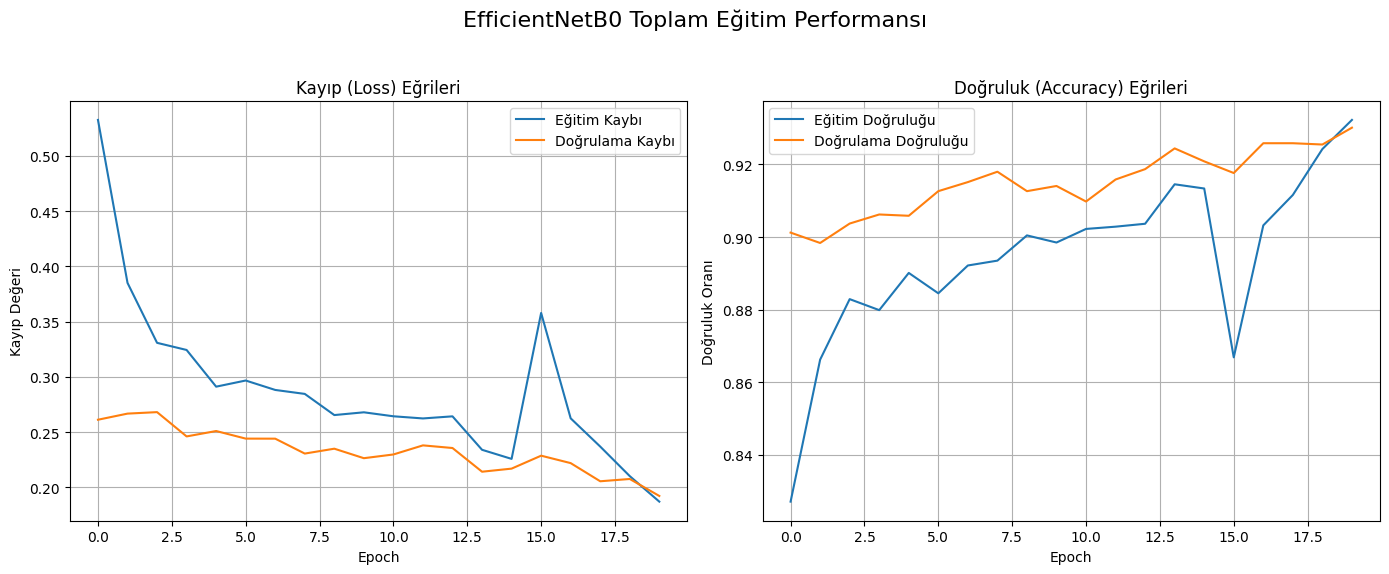

En iyi fine-tuned model ağırlıkları yüklendi.


In [46]:
# İki aşamanın eğitim grafiklerini birleştirerek göster.
def merge_and_plot_histories(h1, h2, title="EfficientNetB0 Toplam Eğitim Performansı"):
    """
    İki eğitim geçmişini birleştirir ve kayıp/doğruluk grafiklerini çizer.
    Args:
        h1 (tf.keras.callbacks.History): İlk eğitim aşamasının geçmişi.
        h2 (tf.keras.callbacks.History): İkinci eğitim aşamasının geçmişi.
        title (str): Grafiğin ana başlığı.
    """
    history = {}
    for key in h1.history:
        history[key] = h1.history[key] + h2.history.get(key, []) # Eğer ikinci geçmişte bir metrik yoksa boş liste ekle

    plt.figure(figsize=(14, 6))
    plt.suptitle(title, fontsize=16)

    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Eğitim Kaybı')
    plt.plot(history['val_loss'], label='Doğrulama Kaybı')
    plt.title('Kayıp (Loss) Eğrileri')
    plt.xlabel('Epoch')
    plt.ylabel('Kayıp Değeri')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label='Eğitim Doğruluğu')
    plt.plot(history['val_accuracy'], label='Doğrulama Doğruluğu')
    plt.title('Doğruluk (Accuracy) Eğrileri')
    plt.xlabel('Epoch')
    plt.ylabel('Doğruluk Oranı')
    plt.legend()
    plt.grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

merge_and_plot_histories(history_eff_1, history_eff_2)
# Ayrıca en iyi modeli yükle (ModelCheckpoint sayesinde en iyi model kaydedilmişti)
try:
    eff_model.load_weights("effnet_b0_finetune.h5")
    print("En iyi fine-tuned model ağırlıkları yüklendi.")
except Exception as e:
    print(f"En iyi fine-tuned model ağırlıkları yüklenemedi: {e}. Mevcut model kullanılacak.")


# Confusion Matrix & Classification Report (EfficientModel)


--- Model Değerlendirmesi (Doğrulama Seti Üzerinde) ---
88/88 ━━━━━━━━━━━━━━━━━━━━ 30s 261ms/step


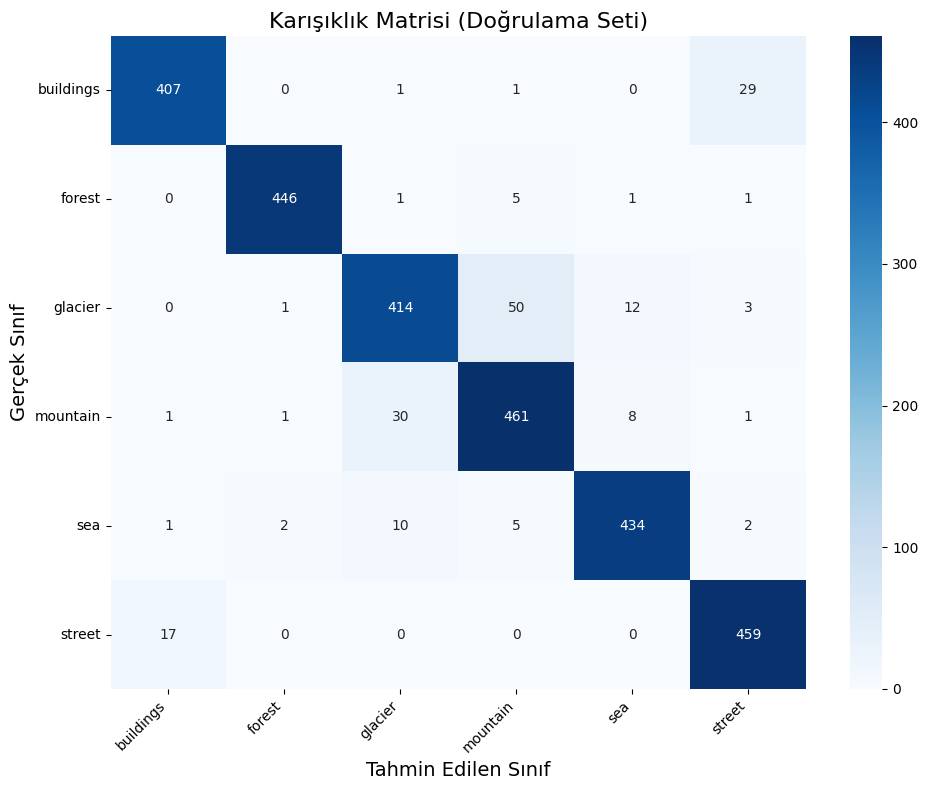


--- Sınıflandırma Raporu (Doğrulama Seti) ---
              precision    recall  f1-score   support

   buildings       0.96      0.93      0.94       438
      forest       0.99      0.98      0.99       454
     glacier       0.91      0.86      0.88       480
    mountain       0.88      0.92      0.90       502
         sea       0.95      0.96      0.95       454
      street       0.93      0.96      0.95       476

    accuracy                           0.93      2804
   macro avg       0.94      0.94      0.94      2804
weighted avg       0.94      0.93      0.93      2804



In [47]:
# --- Hücre 11: Model Değerlendirme - Confusion Matrix ve Classification Report
# Modelin doğrulama seti üzerindeki performansını detaylı olarak değerlendirir.
# Confusion Matrix, her sınıf için doğru ve yanlış sınıflandırmaları gösterirken;
# Classification Report, Precision, Recall ve F1-Score gibi metriklerle sınıf bazında performans analizi sunar.
print("\n--- Model Değerlendirmesi (Doğrulama Seti Üzerinde) ---")

# Doğrulama jeneratörünü sıfırla ve tahminleri al
val_generator.reset()
# verbose=1, tahmin süresince ilerlemeyi gösterir.
preds = eff_model.predict(val_generator, verbose=1)
y_pred = np.argmax(preds, axis=1) # Tahmin edilen sınıf etiketlerini al
y_true = val_generator.classes    # Gerçek sınıf etiketlerini al

# Karışıklık Matrisi (Confusion Matrix) oluşturma ve görselleştirme
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Tahmin Edilen Sınıf', fontsize=14)
plt.ylabel('Gerçek Sınıf', fontsize=14)
plt.title('Karışıklık Matrisi (Doğrulama Seti)', fontsize=16)
plt.xticks(rotation=45, ha='right') # Etiketlerin okunabilirliğini artır
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Sınıflandırma Raporu (Classification Report) yazdırma
# Precision, Recall, F1-Score ve Support metriklerini içerir.
print("\n--- Sınıflandırma Raporu (Doğrulama Seti) ---")
print(classification_report(y_true, y_pred, target_names=classes))



# Confusion Matrix & Classification Report (CNN Model)


--- Basit CNN Modeli Değerlendirmesi (Doğrulama Seti) ---
88/88 ━━━━━━━━━━━━━━━━━━━━ 17s 188ms/step


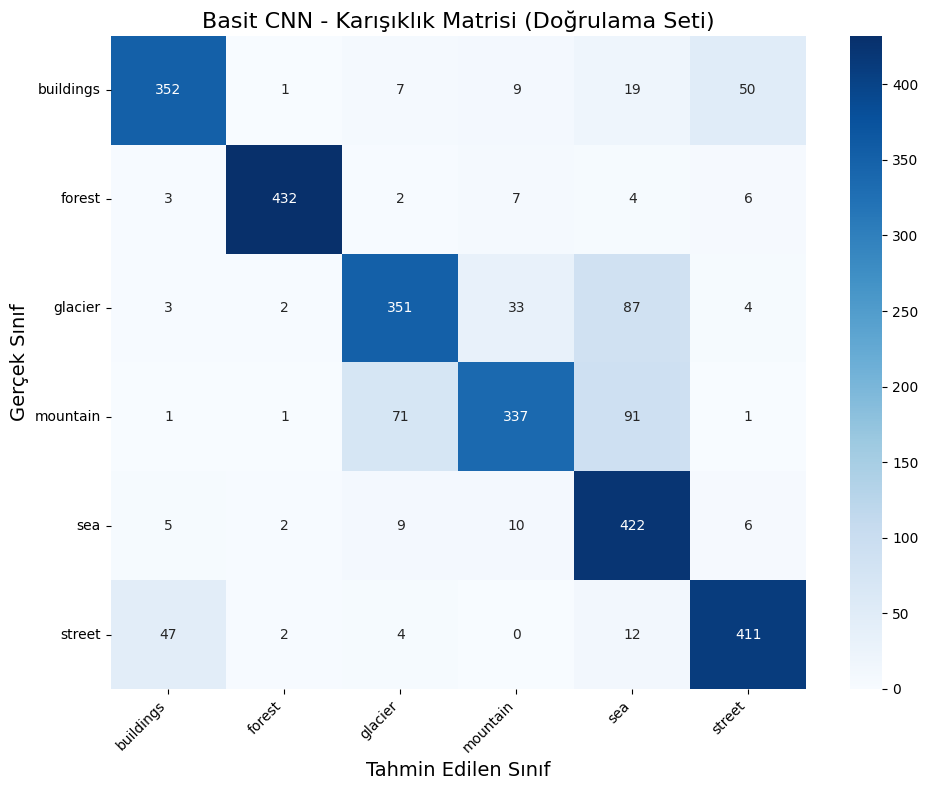


--- Basit CNN Sınıflandırma Raporu (Doğrulama Seti) ---
              precision    recall  f1-score   support

   buildings       0.86      0.80      0.83       438
      forest       0.98      0.95      0.97       454
     glacier       0.79      0.73      0.76       480
    mountain       0.85      0.67      0.75       502
         sea       0.66      0.93      0.78       454
      street       0.86      0.86      0.86       476

    accuracy                           0.82      2804
   macro avg       0.83      0.83      0.82      2804
weighted avg       0.83      0.82      0.82      2804



In [48]:
# --- Basit CNN Modeli Değerlendirmesi (Doğrulama Seti Üzerinde) ---
print("\n--- Basit CNN Modeli Değerlendirmesi (Doğrulama Seti) ---")

# Doğrulama jeneratörünü sıfırla ve tahminleri al
val_generator.reset()
preds_cnn = simple_model.predict(val_generator, verbose=1)
y_pred_cnn = np.argmax(preds_cnn, axis=1)  # Tahmin edilen sınıf etiketleri
y_true = val_generator.classes             # Gerçek sınıf etiketleri

# Confusion Matrix (Karışıklık Matrisi)
cm_cnn = confusion_matrix(y_true, y_pred_cnn)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Tahmin Edilen Sınıf', fontsize=14)
plt.ylabel('Gerçek Sınıf', fontsize=14)
plt.title('Basit CNN - Karışıklık Matrisi (Doğrulama Seti)', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Classification Report (Sınıflandırma Raporu)
print("\n--- Basit CNN Sınıflandırma Raporu (Doğrulama Seti) ---")
print(classification_report(y_true, y_pred_cnn, target_names=classes))
